In [1]:
import warnings
warnings.filterwarnings('ignore',category=RuntimeWarning)
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import glob,os,sys
from tqdm.auto import tqdm
import proplot as plot
import json,pickle
import dask.array as da
import gc
from sklearn.decomposition import PCA
sys.path.insert(1, '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/')
from tools import derive_var,read_and_proc,preproc_noensemble
from tools.mlr import mlr,proc_mlrfcst,maria_IO,ffs
from tools.preprocess import do_eof,preproc_maria,preproc_haiyan
sys.path.insert(2, '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/testML/')
import feature_select
from dask.distributed import Client
client = Client(processes=True, threads_per_worker=1,n_workers=2)
%matplotlib inline

plot.rc.metacolor = 'k'
plot.rc.update({'figure.facecolor':'w','axes.labelweight':'ultralight','tick.labelweight':'ultralight','gridminor.linestyle':'--','title.weight':'normal','linewidth':0.5,'axes.labelweight':'normal',
                'tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 11,'linewidth':1.25})
plot.rc.axesfacecolor = 'w'

distributed.diskutils - INFO - Found stale lock file and directory '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/testML/preproc/Maria/dask-worker-space/worker-gjiif8ja', purging
distributed.diskutils - INFO - Found stale lock file and directory '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/testML/preproc/Maria/dask-worker-space/worker-5pw0w0dr', purging
/tmp/ipykernel_429648/1447050377.py:26: ProplotWarning: rc setting 'linewidth' was renamed to 'meta.width' in version 0.8.
  plot.rc.update({'figure.facecolor':'w','axes.labelweight':'ultralight','tick.labelweight':'ultralight','gridminor.linestyle':'--','title.weight':'normal','linewidth':0.5,'axes.labelweight':'normal',


In [ ]:
path = '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/'
suffix = '_smooth_preproc_dict1b_g'
enter = '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/pca/output/uvwheat/preproc2/'

maria_u = [read_and_proc.depickle(path+'TCGphy/2020_TC_CRF/dev/freddy0218/pca/output/uvwheat/preproc2/'+str(lime)+suffix)['u'] for lime in tqdm(['ctl','ncrf_36h','ncrf_60h','ncrf_96h','lwcrf'])]
divider = np.asarray([maria_u[0][12:].shape[0],maria_u[1][36:].shape[0],maria_u[2][60:].shape[0],maria_u[3][96:].shape[0],maria_u[4][36:].shape[0]]).cumsum()

  0%|          | 0/5 [00:00<?, ?it/s]

#### Preproc pipeline

In [ ]:
def preproc_pipeline(case='Maria',TYPE='3D' or '2D',suffix=None):
    if case=='Maria':
        filepath = input('Enter Path:')
        #------------------------------------------------------------------------------------------------------------------------------------------
        # Import Preprocessed Flat Data and PCA dictionary
        #------------------------------------------------------------------------------------------------------------------------------------------
        if TYPE=='3D':
            tempdict = {}
            for varname in ['u','v','w','qv','theta','heatsum','hdia','rad','ir']:
                temp = [read_and_proc.depickle(filepath+str(lime)+suffix)[varname] for lime in tqdm(['ctl','ncrf_36h','ncrf_60h','ncrf_96h','lwcrf'])]
                tempdict[varname],_ = maria_IO.long_MariaExps(temp)
        elif TYPE=='2D':
            tempdict = {}
            for varname in ['u','v','w','qv','theta','heatsum','hdia','rad','ir']:
                temp = [read_and_proc.depickle(filepath+str(lime)+suffix)[varname] for lime in tqdm(['ctl','ncrf_36h','ncrf_60h','ncrf_96h','lwcrf'])]
                tempdict[varname],_ = maria_IO.long_MariaExps(maria_IO.to_azim(temp))            
        #------------------------------------------------------------------------------------------------------------------------------------------
        # Save to xarray
        #------------------------------------------------------------------------------------------------------------------------------------------
        dims = ['sample','flatarray']
        coords = dict(sample=np.linspace(0,tempdict['u'].shape[0]-1,tempdict['u'].shape[0]),flatarray=np.linspace(0,tempdict['u'].shape[1]-1,tempdict['u'].shape[1]))
        ds = xr.Dataset(coords=coords)
        maria_data=preproc_haiyan.build_a_xarray_dataset(ds=ds,varname=['u','v','w','theta','heatsum','hdia','rad','qv','ir'],\
                                                         varfile=[tempdict['u'],tempdict['v'],tempdict['w'],tempdict['theta'],tempdict['heatsum'],tempdict['hdia'],tempdict['rad'],tempdict['qv'],tempdict['ir']],dims=dims,coords=coords)
        del tempdict
        gc.collect()
        #------------------------------------------------------------------------------------------------------------------------------------------
        # Import PCA dictionary
        #------------------------------------------------------------------------------------------------------------------------------------------
        if TYPE=='3D':
            folderpath='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/testML/output/maria/processed/'
            dict1 = read_and_proc.depickle(folderpath+'PCA/PCAdict2')
        elif TYPE=='2D':
            folderpath='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/testML/output/maria/processed/intermediate/'
            dict1 = read_and_proc.depickle(folderpath+'PCA/PCAdict')

        return maria_data, dict1
    
maria_data, dict1 = preproc_pipeline('Maria','2D','_smooth_preproc_dict1b_g')

#### Prediction

In [4]:
folderpath='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/testML/output/maria/processed/'
modelsDICT = {'model':read_and_proc.depickle(folderpath+'FFW/model'),'reducedX':read_and_proc.depickle(folderpath+'FFW/reducedX'),'newfeature':read_and_proc.depickle(folderpath+'FFW/newfeature')}

In [8]:
#from tools.mlr import cartesian_retrieve
import importlib
importlib.reload(cartesian_retrieve)

<module 'tools.mlr.cartesian_retrieve' from '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/tools/mlr/cartesian_retrieve.py'>

In [10]:
dTRAINdict = cartesian_retrieve.retrieve_cartesian(path,dict1,maria_data,numcomp=[20,11,20,12],\
                                                                                            LT=24,forecastPC=None,target='all',suffix='_smooth_preproc_dict1b_g',case='Maria').windrates_real_maria(uvwheatpath=None,\
                                                                                            LT=24,category='train',testindex=[3])

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [12]:
def long_MariaExps(array=None,testINDEX=None):
    if testINDEX==1:
        haiyan_temparray = [array[0][12:,:],array[1][60:,:],array[2][96:,:],array[3][36:,:]]
    elif testINDEX==2:
        haiyan_temparray = [array[0][12:,:],array[1][36:,:],array[2][96:,:],array[3][36:,:]]
    elif testINDEX==3:
        haiyan_temparray = [array[0][12:,:],array[1][36:,:],array[2][60:,:],array[3][36:,:]]
    elif testINDEX==4:
        haiyan_temparray = [array[0][12:,:],array[1][36:,:],array[2][60:,:],array[3][96:,:]]  
    del array
    gc.collect()
    return np.concatenate(haiyan_temparray,axis=0),[obj.shape for obj in haiyan_temparray]

realSTOREdict = {'u':long_MariaExps(array=dTRAINdict['u'],testINDEX=3)[0],'v':long_MariaExps(array=dTRAINdict['v'],testINDEX=3)[0],'w':long_MariaExps(array=dTRAINdict['w'],testINDEX=3)[0],\
                 'theta':long_MariaExps(array=dTRAINdict['theta'],testINDEX=3)[0],'shape':long_MariaExps(array=dTRAINdict['theta'],testINDEX=3)[1]}

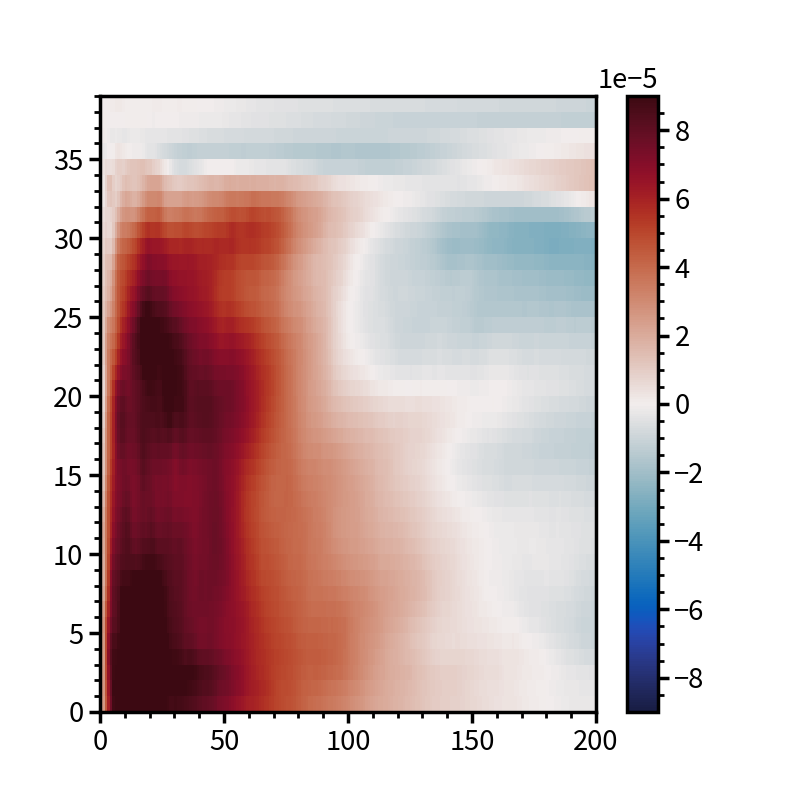

In [26]:
plt.pcolormesh(realSTOREdict['v'][60-12,:].reshape(39,200),vmin=-9e-5,vmax=9e-5,cmap='balance')
plt.colorbar()
plt.show()

In [16]:
MLRpred = modelsDICT['model'][5].predict(modelsDICT['reducedX'][5])

In [17]:
predU,predV,predW,predTHETA = cartesian_retrieve.retrieve_cartesian(path,dict1,maria_data,numcomp=[20,11,20,12],\
                                                   LT=24,forecastPC=None,target='all',suffix='_smooth_preproc_dict1b_g',case='Maria').conversion_predictPC(yforecast=MLRpred,mshpe=None)

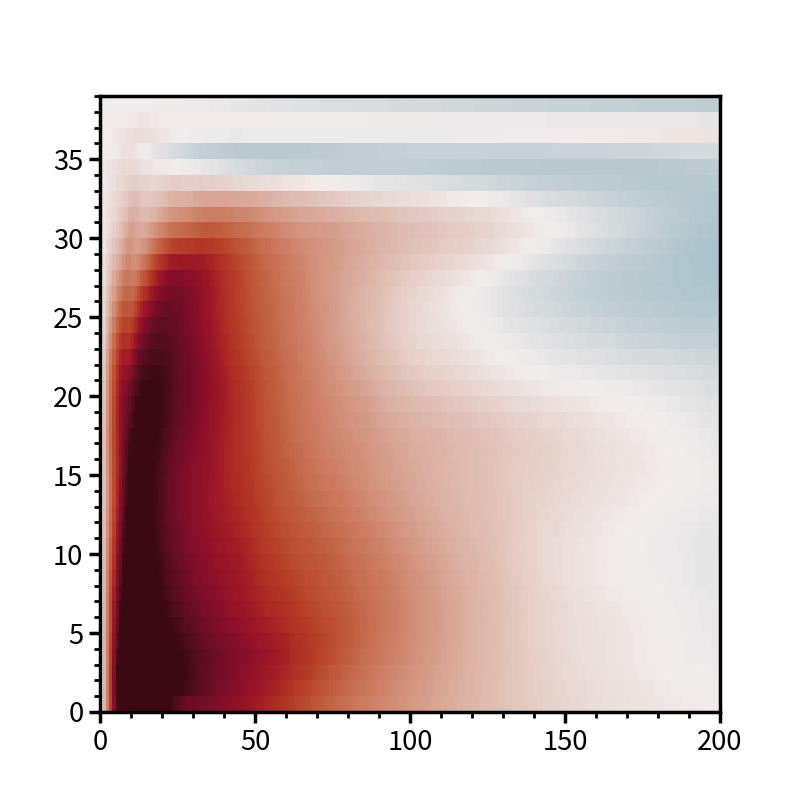

In [28]:
plt.pcolormesh(predV[60-12,:].reshape(39,200),vmin=-9e-5,vmax=9e-5,cmap='balance')
plt.show()

In [30]:
??read_and_proc.depickle

Signature: read_and_proc.depickle(fileloc=None)
Docstring: <no docstring>
Source:   
def depickle(fileloc=None):
    output = []
    with open(fileloc,'rb') as f:
        output.append(pickle.load(f))    
    return output[0]
File:      /work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/tools/read_and_proc.py
Type:      function
